Change endpoint hostname to match your Mongo instance.

In [1]:
import os
os.environ["MONGODB_ENDPOINT"] = "mongodb://localhost:27017"

In [ ]:
from utils import connect_to_mongodb
from pymongo import ASCENDING, DESCENDING

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

db = connect_to_mongodb()

## Basic Flashbots metrics

In [3]:
flashbots_blocks = db.flashbots.flashbots_blocks
results_count = flashbots_blocks.count_documents({})
print("Total Flashbots blocks:", results_count)

min_flashbots_block = flashbots_blocks.find_one(sort=[("block_number", ASCENDING)])
print("Min Flashbots block:", min_flashbots_block["block_number"])
max_flashbots_block = flashbots_blocks.find_one(sort=[("block_number", DESCENDING)])
print("Max Flashbots block:", max_flashbots_block["block_number"])

Total Flashbots blocks: 1196218
Min Flashbots block: 11834049
Max Flashbots block: 14444725


## Analyze bundle types

Number of bundles with the type 'miner_payout': 61500
Number of bundles with the type 'flashbots': 2939980
Number of bundles with the type 'rogue': 247523


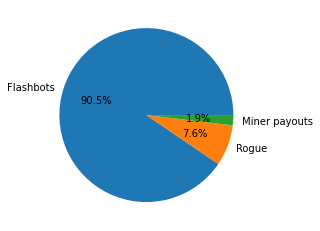

Total number of bundles 3249003
min 1
mean 2.716062624036756
median 2.0
max 42
unique number of bundles per block: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 31, 33, 36, 37, 40, 42}
{1: 382955, 2: 269090, 3: 327785, 4: 74884, 5: 39541, 6: 30288, 7: 18658, 8: 14208, 9: 11147, 10: 14418, 11: 4300, 12: 2286, 13: 1595, 14: 1341, 15: 1499, 16: 708, 17: 337, 18: 291, 19: 326, 20: 482, 21: 22, 22: 23, 23: 5, 24: 7, 26: 2, 27: 5, 28: 4, 29: 4, 31: 2, 33: 1, 36: 1, 37: 1, 40: 1, 42: 1}


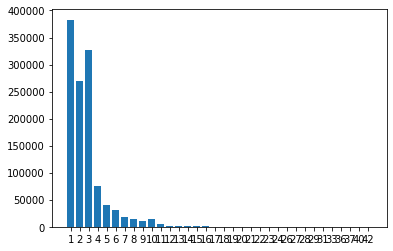

Size of bundles (or transactions per bundle)
min 1
mean 2.1556671385037194
median 1.0
max 700
unique number of transactions per bundle: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 1

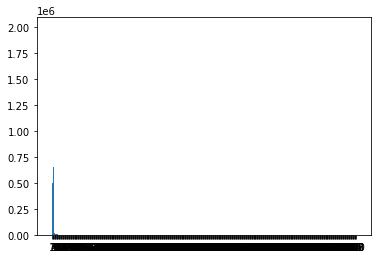

In [4]:
# Analyze bundles
import numpy as np
import matplotlib.pyplot as plt

bundles_per_block = list()
transactions_per_bundle = list()
cursor = flashbots_blocks.find()

miner_payout_transactions_per_bundle = list()
flashbots_transactions_per_bundle = list()
rogue_transactions_per_bundle = list()

for document in cursor:
    bundles_per_block.append(document["transactions"][-1]["bundle_index"] + 1)
    current_bundle_index = 0
    current_bundle_size = 0
    previous_bundle_type = None
    for tx in document["transactions"]:
        if previous_bundle_type == None:
            previous_bundle_type = tx["bundle_type"]
        if current_bundle_index != tx["bundle_index"]:
            if previous_bundle_type == "miner_payout":
                miner_payout_transactions_per_bundle.append(current_bundle_size)
                previous_bundle_type = tx["bundle_type"]
            elif previous_bundle_type == "flashbots":
                flashbots_transactions_per_bundle.append(current_bundle_size)
                previous_bundle_type = tx["bundle_type"]
            elif previous_bundle_type == "rogue":
                rogue_transactions_per_bundle.append(current_bundle_size)
                previous_bundle_type = tx["bundle_type"]
            transactions_per_bundle.append(current_bundle_size)
            current_bundle_index = tx["bundle_index"]
            current_bundle_size = 1
        else:
            current_bundle_size += 1
    if current_bundle_size > 0:
        if previous_bundle_type == "miner_payout":
            miner_payout_transactions_per_bundle.append(current_bundle_size)
        elif previous_bundle_type == "flashbots":
            flashbots_transactions_per_bundle.append(current_bundle_size)
        elif previous_bundle_type == "rogue":
            rogue_transactions_per_bundle.append(current_bundle_size)
        transactions_per_bundle.append(current_bundle_size)
        
print("Number of bundles with the type 'miner_payout':", len(miner_payout_transactions_per_bundle))
print("Number of bundles with the type 'flashbots':", len(flashbots_transactions_per_bundle))
print("Number of bundles with the type 'rogue':", len(rogue_transactions_per_bundle))

fig = plt.figure()
fig.patch.set_facecolor('white')
plt.pie([len(flashbots_transactions_per_bundle), len(rogue_transactions_per_bundle), len(miner_payout_transactions_per_bundle)], labels = ["Flashbots", "Rogue", "Miner payouts"], autopct='%1.1f%%')
plt.show()

assert(sum(bundles_per_block) == len(miner_payout_transactions_per_bundle) + len(flashbots_transactions_per_bundle) + len(rogue_transactions_per_bundle))
assert(sum(transactions_per_bundle) == sum(miner_payout_transactions_per_bundle) + sum(flashbots_transactions_per_bundle) + sum(rogue_transactions_per_bundle))

assert(len(bundles_per_block) == results_count)
assert(sum(bundles_per_block) == len(transactions_per_bundle))

print("Total number of bundles", sum(bundles_per_block))
print("min", np.min(bundles_per_block))
print("mean", np.mean(bundles_per_block))
print("median", np.median(bundles_per_block))
print("max", np.max(bundles_per_block))
print("unique number of bundles per block:", set(bundles_per_block))

a = np.array(bundles_per_block)
unique, counts = np.unique(a, return_counts=True)
D = dict(zip(unique, counts))
print(D)

plt.bar(range(len(D)), list(D.values()), align='center')
plt.xticks(range(len(D)), list(D.keys()))
plt.show()

print("Size of bundles (or transactions per bundle)")
print("min", np.min(transactions_per_bundle))
print("mean", np.mean(transactions_per_bundle))
print("median", np.median(transactions_per_bundle))
print("max", np.max(transactions_per_bundle))
print("unique number of transactions per bundle:", set(transactions_per_bundle))

a = np.array(transactions_per_bundle)
unique, counts = np.unique(a, return_counts=True)
D = dict(zip(unique, counts))
print(D)

plt.bar(range(len(D)), list(D.values()), align='center')
plt.xticks(range(len(D)), list(D.keys()))
plt.show()

# Are bundles always at the top of the block?
# If not, is it always because first come miner payouts?

## Analyze sandwich MEVs

In [5]:
sandwiches = db.flashbots.sandwich_results
total_count = sandwiches.count_documents({})
print("Total sandwiches:", total_count)
flashbots_count = sandwiches.count_documents({"flashbots_bundle":True})
print("Flashbots sandwiches:", flashbots_count)
flash_loan_count = sandwiches.count_documents({"flash_loan":{"$ne":None}})
print("Flash loan sandwiches:", flash_loan_count)
flashbots_flash_loan_count = sandwiches.count_documents({"flashbots_bundle":True, "flash_loan":{"$ne":None}})
print("Flashbots and flash loan sandwiches:", flashbots_flash_loan_count)

Min block: 10000000
Max block: 14444725
Total sandwiches: 1020044
Flashbots sandwiches: 485680
Flash loan sandwiches: 0
Flashbots and flash loan sandwiches: 0


## Analyze arbitrage MEVs

In [6]:
arbitrages = db.flashbots.arbitrage_results
total_count = arbitrages.count_documents({})
print("Total arbitrages:", total_count)
flashbots_count = arbitrages.count_documents({"flashbots_bundle":True})
print("Flashbots arbitrages:", flashbots_count)
flash_loan_count = arbitrages.count_documents({"flash_loan":{"$ne":None}})
print("Flash loan arbitrages:", flash_loan_count)
flashbots_flash_loan_count = arbitrages.count_documents({"flashbots_bundle":True, "flash_loan":{"$ne":None}})
print("Flashbots and flash loan arbitrages:", flashbots_flash_loan_count)
frontrunning_count = arbitrages.count_documents({"frontrunning_arbitrage":True})
print("Frontrunning arbitrages:", frontrunning_count)

Min block: 10000000
Max block: 14444725
Total arbitrages: 3462678
Flashbots arbitrages: 916709
Flash loan arbitrages: 10155
Flashbots and flash loan arbitrages: 1089
Frontrunning arbitrages: 318994


## Analyze liquidation MEVs

In [7]:
liquidations = db.flashbots.liquidation_results
total_count = liquidations.count_documents({})
print("Total liquidations:", total_count)
flashbots_count = liquidations.count_documents({"flashbots_bundle":True})
print("Flashbots liquidations:", flashbots_count)
flash_loan_count = liquidations.count_documents({"flash_loan":{"$ne":None}})
print("Flash loan liquidations:", flash_loan_count)
flashbots_flash_loan_count = liquidations.count_documents({"flashbots_bundle":True, "flash_loan":{"$ne":None}})
print("Flashbots and flash loan liquidations:", flashbots_flash_loan_count)
frontrunning_count = liquidations.count_documents({"frontrunning_liquidation":True})
print("Frontrunning liquidations:", frontrunning_count)

Min block: 10000000
Max block: 14444725
Total liquidations: 32819
Flashbots liquidations: 9191
Flash loan liquidations: 1672
Flashbots and flash loan liquidations: 132
Frontrunning liquidations: 1530


## Count pending transactions

In [8]:
# Analyze pending transactions

pending_transactions = db.flashbots.observed_transactions
total_count = pending_transactions.count_documents({})
print("Total pending transactions:", total_count)

Total pending transactions: 125661539
